In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

D:\programs file\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\programs file\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\programs file\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


# 生成数据集

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)#点积
labels += np.random.normal(scale=0.1, size=labels.shape)#加上噪声均值为0且标准差为0.1的正态分布
poly_features[0,:],poly_features.shape

(array([1.00000000e+00, 1.44377737e+00, 1.04224655e+00, 5.01590661e-01,
        1.81046312e-01, 5.22781136e-02, 1.25796596e-02, 2.59460398e-03,
        4.68253814e-04, 7.51171401e-05, 1.08452427e-05, 1.42346509e-06,
        1.71263891e-07, 1.90205331e-08, 1.96152966e-09, 1.88800809e-10,
        1.70366460e-11, 1.44688965e-12, 1.16054807e-13, 8.81880551e-15]),
 (200, 20))

In [3]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.4438],
         [0.0194]]),
 tensor([[1.0000e+00, 1.4438e+00, 1.0422e+00, 5.0159e-01, 1.8105e-01, 5.2278e-02,
          1.2580e-02, 2.5946e-03, 4.6825e-04, 7.5117e-05, 1.0845e-05, 1.4235e-06,
          1.7126e-07, 1.9021e-08, 1.9615e-09, 1.8880e-10, 1.7037e-11, 1.4469e-12,
          1.1605e-13, 8.8188e-15],
         [1.0000e+00, 1.9353e-02, 1.8727e-04, 1.2081e-06, 5.8451e-09, 2.2624e-11,
          7.2975e-14, 2.0176e-16, 4.8808e-19, 1.0495e-21, 2.0312e-24, 3.5736e-27,
          5.7633e-30, 8.5799e-33, 1.1861e-35, 1.5303e-38, 1.8510e-41, 2.1019e-44,
          0.0000e+00, 0.0000e+00]]),
 tensor([6.0302, 5.0249]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    #画动态图
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式拟合

weight: [[ 5.0103855  1.3157748 -3.3966653  5.3267345]]


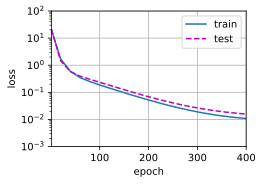

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

## 线性拟合（欠拟合）

weight: [[3.660131  3.2200027]]


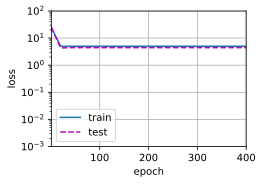

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

## 高阶拟合（过拟合）

weight: [[ 4.9794297   1.2551734  -3.2470186   5.318146   -0.4754036   1.0305514
   0.04687262  0.12603685 -0.14820638 -0.1544499  -0.14901903 -0.06136046
  -0.04197138  0.10142527  0.07705067 -0.22115484 -0.0193487  -0.08080029
  -0.01433885  0.15518868]]


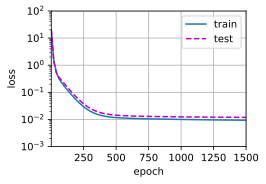

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)